In [20]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator #
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

from keras import layers
from keras import models
from keras import optimizers

from sklearn.utils.class_weight import compute_class_weight
import joblib
from sklearn.metrics import accuracy_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Face_Shapes_2

/content/drive/MyDrive/Face_Shapes_2


In [6]:
# Define directories for train, test and validation data
train_dir = "/content/drive/MyDrive/Face_Shapes_2/Train"
test_dir = "/content/drive/MyDrive/Face_Shapes_2/Test"
validation_dir = "/content/drive/MyDrive/Face_Shapes_2/Validation"

# Define batch size and image size
batch_size = 64
image_size = 128

In [9]:
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

# list containing all the filenames in the dataset
filenames_list = []

# Iterate through categories and filenames, adding them to the respective lists
for category in os.listdir(train_dir):
    for filename in os.listdir(os.path.join(train_dir, category)):
        filenames_list.append(os.path.join(category, filename))
        categories_list.append(category)

# Create a DataFrame with filenames and categories
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  3620


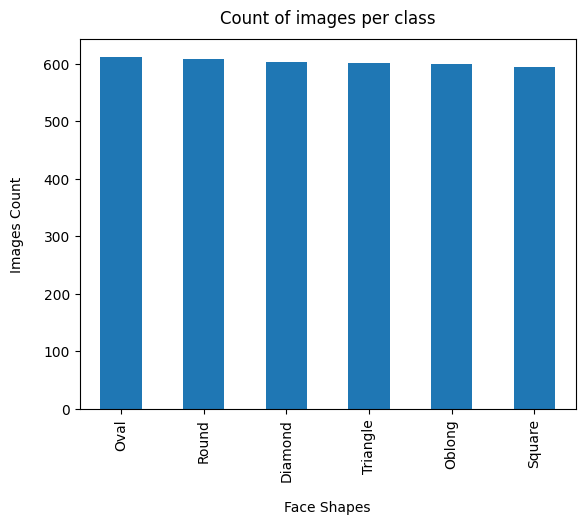

In [10]:
# Createting a barplot to visualize the distribution of images
df_visualization = df.copy()

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Face Shapes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Data is well balanced

In [11]:
# Initialize the ImageDataGenerators for the training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    shuffle=True,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       shuffle=False,
                                                       target_size=(image_size, image_size),
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

Found 3620 images belonging to 6 classes.
Found 1204 images belonging to 6 classes.


In [12]:
# Baseline model
# Defining model architecture
model = models.Sequential()

model.add(layers.Input(shape=(image_size, image_size, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout with rate of 0.25

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout with rate of 0.25

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Add dropout with rate of 0.25

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))   # Add dropout with rate of 0.5
model.add(Dense(6, activation='softmax'))

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

In [14]:
# Print model summary
model.summary()

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model on the training set and validate on the validation set
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=100, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator), 
                    verbose=2,
                    callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [23]:
# Saving model
model.save("Face_Shapes_2.h5")

In [15]:
# Define test data generator and get test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  shuffle=False, 
                                                  target_size=(image_size, image_size), 
                                                  batch_size=batch_size, 
                                                  class_mode='categorical')

# Evaluating the model on the test set
test_x, test_y = next(test_generator)
results_test = model.evaluate(test_x, test_y)

Found 1200 images belonging to 6 classes.
2/2 [==============================] - 1s 228ms/step - loss: 19.2093 - acc: 0.1562


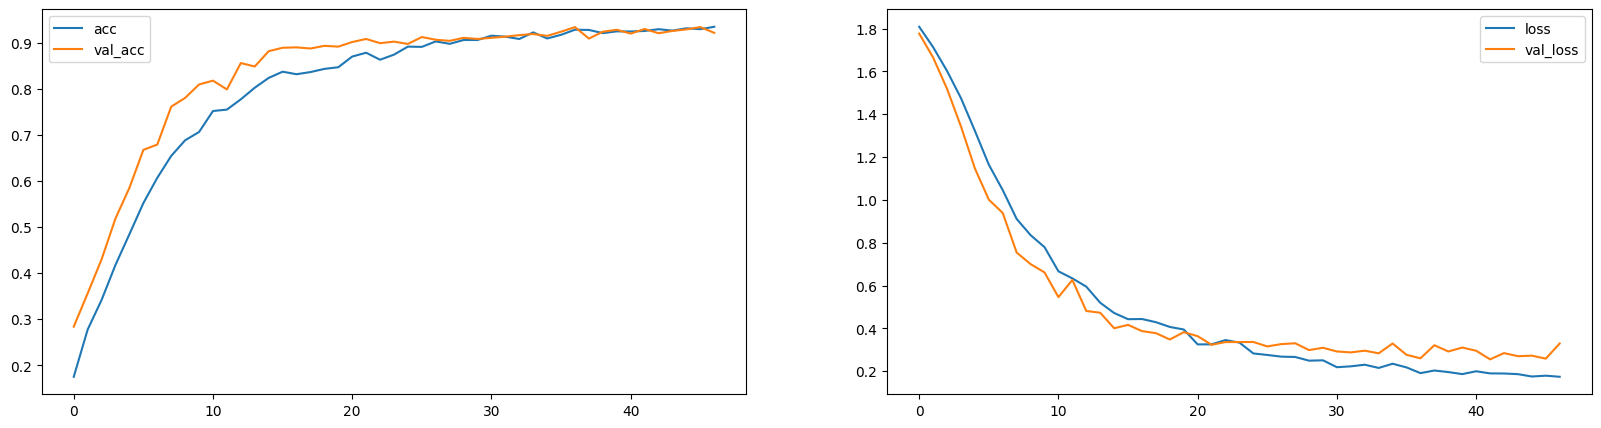

In [16]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [17]:
# Get the predicted probabilities for the validation set
pred_probs = model.predict(validation_generator)

# Convert the probabilities to predicted class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Get the true class labels for the validation set
true_labels = validation_generator.classes

19/19 [==============================] - 19s 950ms/step


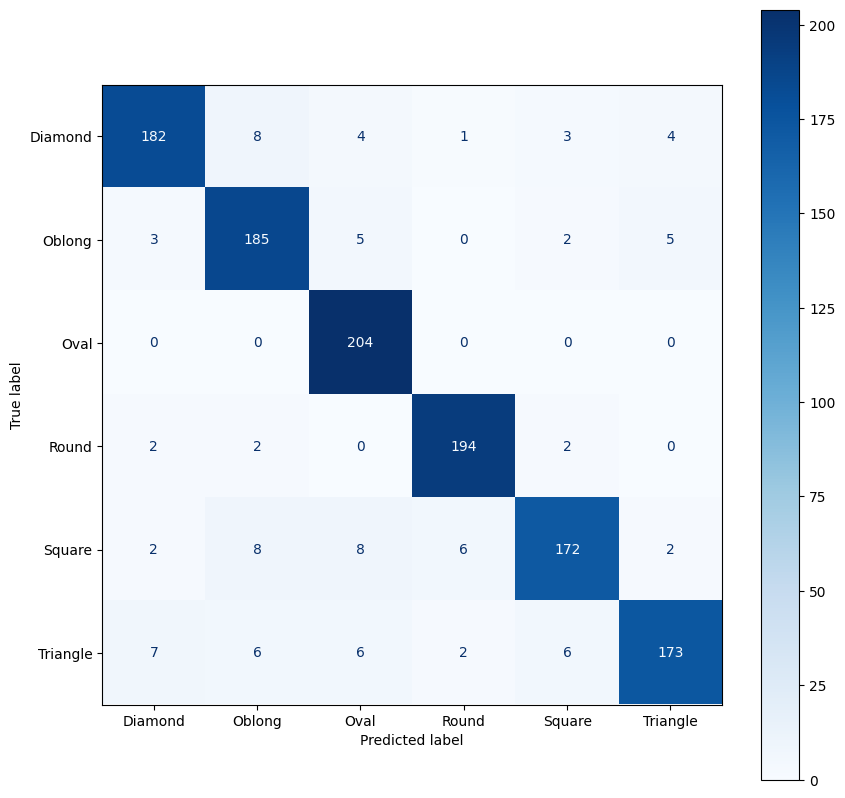

In [18]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [21]:
# Get class names from test generator
class_names = list(test_generator.class_indices.keys())

# Get classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)

# Print report
print(report)

              precision    recall  f1-score   support

     Diamond       0.93      0.90      0.91       202
      Oblong       0.89      0.93      0.90       200
        Oval       0.90      1.00      0.95       204
       Round       0.96      0.97      0.96       200
      Square       0.93      0.87      0.90       198
    Triangle       0.94      0.86      0.90       200

    accuracy                           0.92      1204
   macro avg       0.92      0.92      0.92      1204
weighted avg       0.92      0.92      0.92      1204

